In [1]:
using CSV, DataFrames, Distributions, Gadfly, MLBase, Random, Statistics

## 1. Chargement des données

Assurez vous d'avoir télécharger les données dans le répertoire de ce calepin.

In [2]:
data = CSV.read("train.csv")
first(data,5)

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = read(::String) at CSV.jl:40
└ @ CSV C:\Users\Philippe\.julia\packages\CSV\MKemC\src\CSV.jl:40


5×12 DataFrame. Omitted printing of 6 columns
│ Row │ id    │ radius  │ texture │ perimeter │ area    │ smoothness │
│     │ Int64 │ Float64 │ Float64 │ Float64   │ Float64 │ Float64    │
├─────┼───────┼─────────┼─────────┼───────────┼─────────┼────────────┤
│ 1   │ 1     │ 16.641  │ 21.3452 │ 110.798   │ 901.347 │ 0.112388   │
│ 2   │ 2     │ 13.6884 │ 21.1035 │ 90.5878   │ 578.09  │ 0.0941204  │
│ 3   │ 3     │ 12.9131 │ 14.3055 │ 85.3309   │ 511.539 │ 0.0863069  │
│ 4   │ 4     │ 12.9474 │ 15.1198 │ 86.2821   │ 539.445 │ 0.0925851  │
│ 5   │ 5     │ 19.4972 │ 24.8959 │ 127.491   │ 1200.37 │ 0.101691   │

In [3]:
# Séparation du jeu de données
malign = filter(row -> row.diagnosis == 1, data)
benign = filter(row -> row.diagnosis == 0, data)
n₁ = size(malign, 1)
n₀ = size(benign, 1)
n = n₁ + n₀

455

## 2. Loi prédictive

Après avoir réalisé les calculs pour trouver la loi prédictive pour une loi normale considérant nos a priori non informatifs, on s'assurera qu'elle correspond aussi à une réalisation d'échantillonnage.

In [4]:
loi_inconnue = Normal(5, 2)

Normal{Float64}(μ=5.0, σ=2.0)

In [5]:
n = 150
y = rand.(loi_inconnue for i=1:n)

150-element Array{Float64,1}:
 6.3992013174582745
 2.165968457838767 
 6.439207912792008 
 4.826284746295951 
 3.782639688817372 
 4.039878612858354 
 4.159607489352116 
 5.515729340778912 
 4.85690306488113  
 5.560870932437049 
 2.9112876166458665
 7.3104264149608715
 6.341644867409141 
 ⋮                 
 7.7355925801447745
 6.68576288141181  
 3.050802391084691 
 5.763461026086125 
 4.903805396093562 
 3.9288893354940466
 7.952463244592155 
 1.117500717301132 
 6.361551976352938 
 4.058919599520458 
 4.588894511823537 
 2.726178996710421 

In [6]:
#y = malign[!, :radius]
#n = length(y)

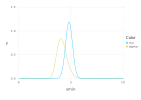

In [7]:
ȳ = mean(y)
SST = sum((y .- ȳ).^2)
s = SST / (n-1)
mμ = LocationScale(ȳ, s/sqrt(n), TDist(n-1))
mσ² = InverseGamma((n-1)/2, 1/2*SST)
plot(
    layer(x -> pdf(mμ, x), 0, 10, color=["mu"]),
    layer(x -> pdf(mσ², x), 0, 10, color=["sigma"])
)

In [8]:
fucked_up_variance = (n+1) * (SST) / (n * (n-2))
dist_pred = LocationScale(ȳ, sqrt(fucked_up_variance), TDist(n-2))

LocationScale{Float64,TDist{Float64}}(
μ: 4.817444014492521
σ: 2.03889902365568
ρ: TDist{Float64}(ν=148.0)
)


In [9]:
# Gibbs avec densités marginales
quantity = 1000000
ỹ = zeros(quantity)
for i=1:quantity
    μ_rand = rand(mμ)
    σ_rand = sqrt(rand(mσ²))
    ỹ[i] = rand(Normal(μ_rand, σ_rand))
end

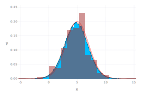

In [10]:
plot(
    layer(x=y, alpha=[0.5],Geom.histogram(bincount=floor(sqrt(n)), density=true), Theme(default_color=colorant"brown")),
    layer(x -> pdf(dist_pred, x), -30, 30, Theme(default_color=colorant"black")),
    layer(x -> pdf(loi_inconnue, x), -30, 30, Theme(default_color=colorant"red")),
    layer(x=ỹ, Geom.histogram(bincount=floor(sqrt(quantity)), density=true)),
    Coord.cartesian(xmin=-5, xmax=15)
)

En noir : loi prédictive <br>
En rouge: loi inconnue <br>
En bleu: valeurs d'échantillonnage <br>

## 3. Application des lois aux données

Pour chaque attribut, on représentera la distribution prédictive.

In [11]:
# Calcul du modèle
function loi_predictive(dataset::Array{Float64})
    ȳ = mean(dataset)
    n = length(dataset)
    SST = sum((dataset .- ȳ).^2)
    fucked_up_variance = (n+1) * (SST) / (n * (n-2))
    return LocationScale(ȳ, sqrt(fucked_up_variance), TDist(n-2))
end

loi_predictive (generic function with 1 method)

In [12]:
n = length(data[!, :id])

455

In [13]:
tag = :radius
pred_radius_0 = loi_predictive(benign[!, tag])
pred_radius_1 = loi_predictive(malign[!, tag])
pred_fit_
plot(
    layer(x->pdf(pred_radius_0, x), 0, 30, Theme(default_color=colorant"black")),
    layer(x->pdf(pred_radius_1, x), 0, 30, Theme(default_color=colorant"black")),
    layer(malign, x=tag, Geom.histogram(bincount=floor(sqrt(n₁)), density=true), color = ["malign"]),
    layer(benign, x=tag, alpha=[0.75], Geom.histogram(bincount=floor(sqrt(n₀)), density=true), color = ["benign"])
)

UndefVarError: UndefVarError: pred_fit_ not defined

In [14]:
tags = [:radius,:texture,:perimeter,:area,:smoothness,:compactness,
    :concavity,:concave_points,:symmetry,:fractal_dimension]
plots = []
preds_0 = []
preds_1 = []
for tag in tags
    pred_0 = loi_predictive(benign[!, tag])
    pred_1 = loi_predictive(malign[!, tag])
    push!(preds_0, pred_0)
    push!(preds_1, pred_1)
    max₀ = maximum(benign[!, tag])
    max₁ = maximum(malign[!, tag])
    push!(plots, plot(
        layer(x->pdf(pred_0, x), 0, 1.2 * max₀, Theme(default_color=colorant"black")),
        layer(x->pdf(pred_1, x), 0, 1.2 * max₁, Theme(default_color=colorant"black")),
        layer(malign, x=tag, Geom.histogram(bincount=floor(sqrt(n₁)), density=true), color = ["malign"]),
        layer(benign, x=tag, Geom.histogram(bincount=floor(sqrt(n₀)), density=true), color = ["benign"])
    ))
end

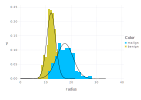

In [15]:
plots[1]

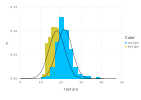

In [16]:
plots[2]

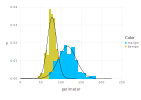

In [17]:
plots[3]

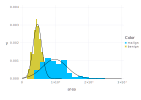

In [18]:
plots[4]

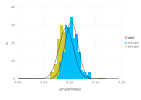

In [19]:
plots[5]

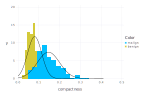

In [20]:
plots[6]

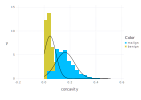

In [21]:
plots[7]

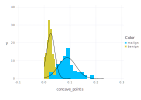

In [22]:
plots[8]

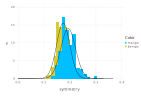

In [23]:
plots[9]

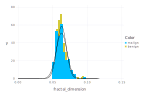

In [24]:
plots[10]

Si l'on utilise uniquement ces lois avec le modèle bayésien naïf (voir section 4), on obtient un score de 89% sur les données d'entrainement, et de 78% sur les données de test. On peux donc faire mieux!

## 3.2 Recherche de nouvelles lois

La loi normale semble convenir pour la plupart des attributs. Néanmoins, pour la compacité et la concavité, il est clair que de meilleures lois peuvent être définies.

Le temps nous étant compté, on utilisera cette fois la fonction *fit* pour approximer la loi a posteriori. Ainsi, au lieu d'utiliser la vraie loi prédicitve, on se servira d'estimateurs. On fera donc la même approximation que dans le devoir 8:

$$f_{(\tilde{X}_1|\tilde{Y}=0)}(\tilde{x}_1) \approx f_{(\tilde{X}_1|\tilde{Y}=0, \hat{\boldsymbol{\theta}}_{01})}(\tilde{x}_1)$$

On commencera avec les lois qui nous semblent les plus probables sur la compacité des tumeurs bénignes.

In [25]:
gamma = fit(Gamma{Float64}, benign[!, :compactness])
beta = fit(Beta{Float64}, benign[!, :compactness])
lognormal = fit(LogNormal{Float64}, benign[!, :compactness])

LogNormal{Float64}(μ=-2.6110368057024393, σ=0.40720069424215255)

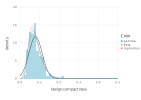

In [26]:
plot(
    layer(x -> pdf(gamma, x), 0, 0.5, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.5, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.5, color=["lognormal"]),
    layer(x -> pdf(preds_0[6], x), 0, 0.5, Theme(default_color=colorant"black")),
    layer(x=benign[!, :compactness], Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("benign.compactness"), Guide.ylabel("density")
)

Ces trois lois semblent mieux décrire la compacité des tumeurs que la loi normale. Pour comparer les différents modèles, nous utiliserons le BIC.

In [27]:
# Tous nos modèles ont deux paramètres
# k=2
df_bic = DataFrame(Model = String[], BIC=Float64[])
push!(df_bic, ["student", loglikelihood(preds_0[6], benign[!, :compactness]) - log(n₀)])
push!(df_bic, ["gamma", loglikelihood(gamma, benign[!, :compactness]) - log(n₀)])
push!(df_bic, ["beta", loglikelihood(beta, benign[!, :compactness]) - log(n₀)])
push!(df_bic, ["lognormal", loglikelihood(lognormal, benign[!, :compactness]) - log(n₀)])

4×2 DataFrame
│ Row │ Model     │ BIC     │
│     │ String    │ Float64 │
├─────┼───────────┼─────────┤
│ 1   │ student   │ 554.637 │
│ 2   │ gamma     │ 585.012 │
│ 3   │ beta      │ 582.395 │
│ 4   │ lognormal │ 588.566 │

Devançant la loi gamma de presque trois points, le modèle le plus probable pour nos données est la lognormale, ce qui semble correspondre à ce qu'on peut voir sur le graphique plus haut. Nous allons maintenant appliquer ces mêmes modèles aux autres attributs. Nous en profiterons aussi pour voir la qualité de la loi prédictive par rapport à la loi normale avec paramètres estimés.

In [28]:
bic_malign = DataFrame(Student = Float64[], Normal=Float64[], Gamma=Float64[], Beta=Float64[], LogNormal=Float64[])
for i=1:10
    tag = tags[i]
    y = malign[:, tag]
    gammaValid = minimum(y) > 0
    betaValid = minimum(y) >= 0 && maximum(y) <=1

    push!(bic_malign, [
        loglikelihood(preds_1[i], y) - log(n₀),
        loglikelihood(fit(Normal, y), y) - log(n₀),
        gammaValid ? loglikelihood(fit(Gamma{Float64}, y), y) - log(n₀) : -Inf,
        betaValid ? loglikelihood(fit(Beta{Float64}, y), y) - log(n₀) : -Inf,
        gammaValid ? loglikelihood(fit(LogNormal{Float64}, y), y) - log(n₀) : -Inf
    ])
end
bic_malign

10×5 DataFrame
│ Row │ Student  │ Normal   │ Gamma    │ Beta    │ LogNormal │
│     │ Float64  │ Float64  │ Float64  │ Float64 │ Float64   │
├─────┼──────────┼──────────┼──────────┼─────────┼───────────┤
│ 1   │ -447.939 │ -447.95  │ -445.529 │ -Inf    │ -445.683  │
│ 2   │ -476.387 │ -476.961 │ -472.313 │ -Inf    │ -472.005  │
│ 3   │ -775.818 │ -775.854 │ -772.596 │ -Inf    │ -772.407  │
│ 4   │ -1256.52 │ -1256.84 │ -1245.02 │ -Inf    │ -1244.61  │
│ 5   │ 502.377  │ 502.358  │ 504.855  │ 504.623 │ 505.507   │
│ 6   │ 253.247  │ 253.091  │ 261.972  │ 261.443 │ 260.628   │
│ 7   │ 202.449  │ 202.287  │ 207.134  │ 208.077 │ 197.659   │
│ 8   │ 332.063  │ 331.968  │ 336.339  │ 336.652 │ 330.856   │
│ 9   │ 362.142  │ 361.858  │ 366.592  │ 365.533 │ 367.963   │
│ 10  │ 583.289  │ 582.984  │ 588.615  │ 588.13  │ 590.802   │

In [29]:
bic_benign = DataFrame(Student = Float64[], Normal=Float64[], Gamma=Float64[], Beta=Float64[], LogNormal=Float64[])
for i=1:10
    tag = tags[i]
    y = benign[:, tag]
    gammaValid = minimum(y) > 0
    betaValid = minimum(y) >= 0 && maximum(y) <=1

    push!(bic_benign, [
        loglikelihood(preds_0[i], y) - log(n₀),
        loglikelihood(fit(Normal, y), y) - log(n₀),
        gammaValid ? loglikelihood(fit(Gamma{Float64}, y), y) - log(n₀) : -Inf,
        betaValid ? loglikelihood(fit(Beta{Float64}, y), y) - log(n₀) : -Inf,
        gammaValid ? loglikelihood(fit(LogNormal{Float64}, y), y) - log(n₀) : -Inf
    ])
end
bic_benign

10×5 DataFrame
│ Row │ Student  │ Normal   │ Gamma    │ Beta    │ LogNormal │
│     │ Float64  │ Float64  │ Float64  │ Float64 │ Float64   │
├─────┼──────────┼──────────┼──────────┼─────────┼───────────┤
│ 1   │ -563.354 │ -563.365 │ -566.61  │ -Inf    │ -569.844  │
│ 2   │ -799.028 │ -799.284 │ -783.953 │ -Inf    │ -779.347  │
│ 3   │ -1103.86 │ -1103.86 │ -1107.36 │ -Inf    │ -1110.84  │
│ 4   │ -1791.13 │ -1791.23 │ -1790.29 │ -Inf    │ -1796.35  │
│ 5   │ 806.006  │ 805.65   │ 813.816  │ 813.002 │ 816.184   │
│ 6   │ 554.637  │ 554.0    │ 585.012  │ 582.395 │ 588.566   │
│ 7   │ 481.238  │ 476.358  │ -Inf     │ -Inf    │ -Inf      │
│ 8   │ 772.072  │ 771.793  │ -Inf     │ -Inf    │ -Inf      │
│ 9   │ 634.021  │ 633.71   │ 640.159  │ 638.974 │ 641.573   │
│ 10  │ 1011.65  │ 1010.64  │ 1023.85  │ 1022.49 │ 1029.42   │

On voit que pour certaines variables, notamment la compacité (index 6), le BIC penche décisivement en faveur des autres modèles (différence supérieure à 2). On remarque au passage que, pour un modèle utilisant la loi normale, le facteur de Bayes entre la loi prédictive et l'estimation par maximum de vraisemblance penche toujours en faveur de la loi prédictive, mais rarement de façon décisive.

Néanmoins, certaines des valeurs de concavité (index 7 et 8) sont en dessous de 0 dans les tumeurs bénignes. C'est plutôt dommage, surtout que visuellement, la loi normale était plutôt mauvaise pour modéliser ces valeurs! De plus, selon le BIC, ces modèles conviennent mieux aux valeurs des tumeurs malignes, comme on peut le voir ci-dessous:

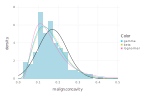

In [30]:
y = malign[:, :concavity]

gamma = fit(Gamma{Float64}, y)
beta = fit(Beta{Float64}, y)
lognormal = fit(LogNormal{Float64}, y)

plot(
    layer(x -> pdf(gamma, x), 0, 0.5, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.5, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.5, color=["lognormal"]),
    layer(x -> pdf(preds_1[7], x - 0.01), 0, 0.5, Theme(default_color=colorant"black")),
    layer(x=y, Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("malign.concavity"), Guide.ylabel("density")
)

On tentera donc de gérer ces valeurs négatives, pour utiliser les lois proposées sur les données de concavité.

In [31]:
minimum(benign[!, tags[7]])

-0.0007679639517163341

In [32]:
minimum(benign[!, tags[8]])

-0.0004537938092701921

In [33]:
count(val-> val <= 0, benign[:, :concavity])

4

In [34]:
count(val-> val <= 0, benign[:, :concave_points])

3

Très peu de valeurs sont inférieures ou égales à 0, et celles qui le sont sont très proches de 0. On peut donc se permettre de les ramener à une valeur juste au-dessus de 0.

Il faudra toutefois se rappeler d'effectuer la même transformation aux données de test!

On commencera avec la concavité.

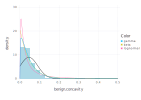

In [35]:
y = benign[:, :concavity]
y = map(val -> val <= 0 ? 0.0001 : val, y)

gamma = fit(Gamma{Float64}, y)
beta = fit(Beta{Float64}, y)
lognormal = fit(LogNormal{Float64}, y)

plot(
    layer(x -> pdf(gamma, x), 0, 0.5, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.5, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.5, color=["lognormal"]),
    layer(x -> pdf(preds_0[7], x), 0, 0.5, Theme(default_color=colorant"black")),
    layer(x=y, Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("benign.concavity"), Guide.ylabel("density")
)

In [36]:
# Tous nos modèles ont deux paramètres
# k=2
df_bic = DataFrame(Model = String[], BIC=Float64[])
push!(df_bic, ["student", loglikelihood(preds_0[7], y) - log(n₀)])
push!(df_bic, ["gamma", loglikelihood(gamma, y) - log(n₀)])
push!(df_bic, ["beta", loglikelihood(beta, y) - log(n₀)])
push!(df_bic, ["lognormal", loglikelihood(lognormal, y) - log(n₀)])

4×2 DataFrame
│ Row │ Model     │ BIC     │
│     │ String    │ Float64 │
├─────┼───────────┼─────────┤
│ 1   │ student   │ 481.308 │
│ 2   │ gamma     │ 585.652 │
│ 3   │ beta      │ 583.001 │
│ 4   │ lognormal │ 525.976 │

Tous ces modèles sont nettements suprérieures à la loi normale. On remarque toutefois sur le graphique qu'ils ne semblent pas très bien suivre les données. On tentera donc un autre technique pour inclure les valeurs négative : décaler les données.

Le décalage de 0.01 a été choisi visuellement comme celui qui permet aux lois de mieux suivre les données. On pourrait faire un travail pour maximiser la vraisemblance de ce paramètre, mais pour l'instant, comme nous voulons vraiment juste améliorer nos prédictions par rapport à la loi normale, nous nous sommes contentés de cette approximation.

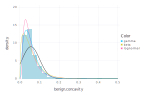

In [37]:
decalage = 0.01
y = benign[:, :concavity] .+ decalage

gamma = fit(Gamma{Float64}, y)
beta = fit(Beta{Float64}, y)
lognormal = fit(LogNormal{Float64}, y)

plot(
    layer(x -> pdf(gamma, x), 0, 0.5, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.5, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.5, color=["lognormal"]),
    layer(x -> pdf(preds_0[7], x - decalage), 0, 0.5, Theme(default_color=colorant"black")),
    layer(x=y, Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("benign.concavity"), Guide.ylabel("density")
)

In [38]:
decalage = 0.01
y = benign[:, :concavity] .+ decalage
# Pour calculer le BIC avec ces nouvelles données, on devra adapter la loi prédictive
pred = loi_predictive(y)

df_bic = DataFrame(Model = String[], BIC=Float64[])
push!(df_bic, ["student", loglikelihood(pred, y) - log(n₀)])
# Le rajout du paramètre de décalage rajoute un paramètre à notre modèle!
# Cela n'affecte pas la loi normale, puisque ce paramètre correspond à la moyenne.
# k=3
push!(df_bic, ["gamma", loglikelihood(gamma, y) - 3/2 * log(n₀)])
push!(df_bic, ["beta", loglikelihood(beta, y) - 3/2 * log(n₀)])
push!(df_bic, ["lognormal", loglikelihood(lognormal, y) - 3/2 * log(n₀)])

4×2 DataFrame
│ Row │ Model     │ BIC     │
│     │ String    │ Float64 │
├─────┼───────────┼─────────┤
│ 1   │ student   │ 481.238 │
│ 2   │ gamma     │ 574.071 │
│ 3   │ beta      │ 556.268 │
│ 4   │ lognormal │ 582.719 │

La gamma de la première mise à niveau a à peu près le même BIC que la lognormae de la seconde. On peut donc choisir l'un ou l'autre de ces modèles.

On poursuit avec les points concaves. On appliquera la même démarche que pour la concavité.

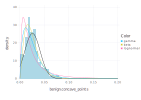

In [39]:
y = benign[:, :concave_points]
y = map(val -> val <= 0 ? 0.0001 : val, y)

gamma = fit(Gamma{Float64}, y)
beta = fit(Beta{Float64}, y)
lognormal = fit(LogNormal{Float64}, y)

plot(
    layer(x -> pdf(gamma, x), 0, 0.2, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.2, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.2, color=["lognormal"]),
    layer(x -> pdf(preds_0[8], x), 0, 0.2, Theme(default_color=colorant"black")),
    layer(x=y, Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("benign.concave_points"), Guide.ylabel("density")
)

In [40]:
# Tous nos modèles ont deux paramètres
# k=2
df_bic = DataFrame(Model = String[], BIC=Float64[])
push!(df_bic, ["student", loglikelihood(preds_0[8], y) - log(n₀)])
push!(df_bic, ["gamma", loglikelihood(gamma, y) - log(n₀)])
push!(df_bic, ["beta", loglikelihood(beta, y) - log(n₀)])
push!(df_bic, ["lognormal", loglikelihood(lognormal, y) - log(n₀)])

4×2 DataFrame
│ Row │ Model     │ BIC     │
│     │ String    │ Float64 │
├─────┼───────────┼─────────┤
│ 1   │ student   │ 772.215 │
│ 2   │ gamma     │ 778.337 │
│ 3   │ beta      │ 768.9   │
│ 4   │ lognormal │ 709.116 │

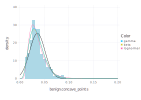

In [41]:
y = benign[:, :concave_points]
y = y .+ 0.01

gamma = fit(Gamma{Float64}, y)
beta = fit(Beta{Float64}, y)
lognormal = fit(LogNormal{Float64}, y)

plot(
    layer(x -> pdf(gamma, x), 0, 0.2, color=["gamma"]),
    layer(x -> pdf(beta, x), 0, 0.2, color=["beta"]),
    layer(x -> pdf(lognormal, x), 0, 0.2, color=["lognormal"]),
    layer(x -> pdf(preds_0[8], x-0.01), 0, 0.2, Theme(default_color=colorant"black")),
    layer(x=y, Geom.histogram(bincount = floor(sqrt(n₀)), density=true), 
        Theme(default_color=colorant"lightblue")),
    Guide.xlabel("benign.concave_points"), Guide.ylabel("density")
)

In [42]:
df_bic = DataFrame(Model = String[], BIC=Float64[])
push!(df_bic, ["student", loglikelihood(loi_predictive(y), y) - log(n₀)])
push!(df_bic, ["gamma", loglikelihood(gamma, y) - 3/2 * log(n₀)])
push!(df_bic, ["beta", loglikelihood(beta, y) - 3/2 * log(n₀)])
push!(df_bic, ["lognormal", loglikelihood(lognormal, y) - 3/2 * log(n₀)])

4×2 DataFrame
│ Row │ Model     │ BIC     │
│     │ String    │ Float64 │
├─────┼───────────┼─────────┤
│ 1   │ student   │ 772.072 │
│ 2   │ gamma     │ 791.125 │
│ 3   │ beta      │ 790.873 │
│ 4   │ lognormal │ 787.946 │

## 3.3 Choix du modèle

Donnant suite à notre analyse exploratoire, nous avons choisi les modèles que seront utlisés pour le bayésien naïf. Nous en avons aussi profité pour sélectionner les variables, en fonction de leur pertinence et de la colinéarité.

Les variables perimeter, area et concave_points seront retirées ainf de diminuer la multicolinéarité. On enlève aussi fractal_dimensions, qui n'est visuellement pas pertinente.

Cela nous laisse avec les variables suivantes, que nous modéliserons avec le modèle qui présente de le meilleur BIC. En cas de doute ($\Delta$BIC < 2), on choisit un modèle qui convient aux deux ensembles de données, par souci de cohérence.
- radius : Normale
- texture : LogNormale
- smoothness : LogNormale
- compactness : LogNormale
- concavity : Gamma (avec modification des valeurs négatives)
- symmetry : LogNormale

In [43]:
variables = [1, 2, 5, 6, 7, 9]

for i=[2, 5, 6, 9]
    preds_0[i] = fit(LogNormal, benign[:, tags[i]])
    preds_1[i] = fit(LogNormal, malign[:, tags[i]])
end

preds_0[7] = fit(Gamma, map(val-> val <= 0 ? 0.0001 : val, benign[:, :concavity]))
preds_1[7] = fit(Gamma, malign[:, :concavity])

Gamma{Float64}(α=4.617073814995688, θ=0.03501547207251189)

In [44]:
for i=variables
    y₁ = malign[:, tags[i]]
    y₀ = benign[:, tags[i]]
    plots[i] = plot(
        layer(x->pdf(preds_0[i], x), 0, 1.2 * maximum(y₀), Theme(default_color=colorant"black")),
        layer(x->pdf(preds_1[i], x), 0, 1.2 * maximum(y₁), Theme(default_color=colorant"black")),
        layer(x=y₁, Geom.histogram(bincount=floor(sqrt(n₁)), density=true), color = ["malign"]),
        layer(x=y₀, Geom.histogram(bincount=floor(sqrt(n₀)), density=true), color = ["benign"])
    )
end

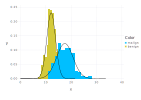

In [45]:
plots[1]

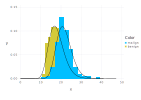

In [46]:
plots[2]

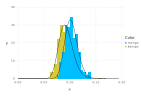

In [47]:
plots[5]

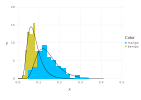

In [48]:
plots[6]

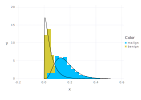

In [49]:
plots[7]

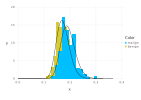

In [50]:
plots[9]

## 4. Probabilité d'une tumeur maligne

On utilisera un modèle bayésien naïf à plusieurs variables pour déterminer si une tumeur est maligne ou bénigne

In [51]:
α = 1
β = 1
n₀ = size(benign, 1)
n₁ = size(malign, 1)
n = n₀ + n₁
p₀ = (β + n₀)/(α + β + n)
p₁ = (α + n₁)/(α + β + n)

0.37636761487964987

In [52]:
function vraisemblance_maligne(row::DataFrameRow, selected_variables)
    q₀ = log(p₀)
    q₁ = log(p₁)
    
    for i=selected_variables
        q₀ += log(pdf(preds_0[i], row[tags[i]]))
        
        q₁ += log(pdf(preds_1[i], row[tags[i]]))
    end

    return q₁ - q₀
end

vraisemblance_maligne (generic function with 1 method)

In [53]:
results = map(row -> vraisemblance_maligne(row, variables), eachrow(data))

455-element Array{Float64,1}:
   7.677242501103633 
  -4.041046451650609 
  -2.3599692634155307
  -3.772994046957568 
  10.864486813432784 
   1.57000427199612  
  27.056348836140415 
   4.045170695603826 
   4.141190805117005 
 -18.553807545206887 
 -21.791476919686524 
  10.449526337857405 
  -7.5099630247763685
   ⋮                 
  -2.2130731127255165
  -5.856395046311958 
  -7.413771235130006 
  17.908851068104266 
  -4.6058580700486145
  -4.006856423117462 
  -3.0936253174729083
  -9.21365100329951  
  -5.6450520459289795
  -2.4139923632527336
  -1.3252381045859818
  12.433625513639338 

In [54]:
predictions = results .> 0

455-element BitArray{1}:
  true
 false
 false
 false
  true
  true
  true
  true
  true
 false
 false
  true
 false
     ⋮
 false
 false
 false
  true
 false
 false
 false
 false
 false
 false
 false
  true

In [55]:
mean(predictions)

0.3868131868131868

In [56]:
correctrate(data[!, :diagnosis], predictions)

0.9274725274725275

### 4.1 Cross validation

Nous nous sommes demandés si enlever des variables colinéaires améliorait effectivement les prédictions. Pour cela, il faut séprarer notre ensemble de données entre entrainement et validation, puisque si l'utilisation de toutes les variables va toujours améliorer notre précision sur l'ensemble d'entrainement, elle peut la réduire sur une ensemble de test.

Il faut aussi choisir des lois pour les autres variables que nous avions rejetées.

- perimeter : Normale
- area : Normale
- concave_points : Gamma avec recentrage des données
- fractal_dimension : LogNormale

In [57]:
# K-cross validation
function find_all_indexes(length, nb_blocks)
    return [convert(Int64, floor((i-1)*length/nb_blocks)+1) for i = 1:nb_blocks]
end

nb_blocks = 5
malign_indexes = find_all_indexes(n₁, nb_blocks)
push!(malign_indexes, n₁)
benign_indexes = find_all_indexes(n₀, nb_blocks)
push!(benign_indexes, n₀)

6-element Array{Int64,1}:
   1
  57
 114
 171
 228
 284

In [58]:
function split_data(i::Int64)
    m_range = malign_indexes[i]:malign_indexes[i+1]
    malign_valid = malign[m_range, :]
    malign_train = malign[Not(m_range), :]

    b_range = benign_indexes[i]:benign_indexes[i+1]
    benign_valid = benign[m_range, :]
    benign_train = benign[Not(m_range), :]
    
    return malign_valid, malign_train, benign_valid, benign_train
end

split_data (generic function with 1 method)

On peut maintenant appliquer nos modèles à chaque bloc

In [59]:
rates_all = []
rates_selected = []
selected_variables = [1, 2, 5, 6, 7, 9]
for i=1:nb_blocks
    m_valid, m_train, b_valid, b_train = split_data(i)
    
    # Lois normales
    for attr=[1, 3, 4]
        preds_0[attr] = loi_predictive(b_train[:, tags[attr]])
        preds_1[attr] = loi_predictive(m_train[:, tags[attr]])
    end
    
    # Lois lognormales
    for attr=[2, 5, 6, 9, 10]
        preds_0[attr] = fit(LogNormal, b_train[:, tags[attr]])
        preds_1[attr] = fit(LogNormal, m_train[:, tags[attr]])
    end
    
    # Lois gamma
    # Pour la concavité des tumeurs bénignes, on modifie les points sous 0
    # On n'applique pas ces modifications aux tumeurs malignes, puisqu'aucune valeur ne se trouve sous 0
    y = map(val -> val <=0 ? 0.00001 : val, b_train[:, :concavity])
    preds_0[7] = fit(Gamma, y)
    preds_1[7] = fit(Gamma, m_train[:, :concavity])
    # Pour les points concaves des tumeurs bénignes, on décale tout de 0.01
    # Ces modifications devront aussi s'appliquer aux tumeurs malignes
    preds_0[8] = fit(Gamma, b_train[:, :concave_points] .+ 0.01)
    preds_1[8] = fit(Gamma, m_train[:, :concave_points] .+ 0.01)
    
    # Il faut appliquer les mêmes changements à l'ensemble de validation
    valid = append!(m_valid, b_valid)
    valid[!, :concavity] = map(val -> val <=0 ? 0.00001 : val, valid[:, :concavity])
    valid[!, :concave_points] = valid[:, :concave_points] .+ 0.01
    
    # Prédictions avec variables sélectionnées
    predictions = map(row -> vraisemblance_maligne(row, selected_variables) > 0, eachrow(valid))
    push!(rates_selected, correctrate(predictions, valid.diagnosis))
    
    # Prédictions avec toutes les variables
    predictions = map(row -> vraisemblance_maligne(row, 1:10) > 0, eachrow(valid))
    push!(rates_all, correctrate(predictions, valid.diagnosis))
end

In [60]:
mean(rates_all)

0.9285714285714286

In [61]:
mean(rates_selected)

0.917142857142857

Notre modèle ne semble pas être trop sensible à la colinéarité, ou aux variables presque inutiles. On peut donc se peremttre d'utiliser l'ensemble des variables pour le modèle final.

### 4.2 Application du modèle à l'ensemble de test

In [62]:
test = CSV.read("test.csv")
first(test, 5)

5×11 DataFrame. Omitted printing of 5 columns
│ Row │ id    │ radius  │ texture │ perimeter │ area    │ smoothness │
│     │ Int64 │ Float64 │ Float64 │ Float64   │ Float64 │ Float64    │
├─────┼───────┼─────────┼─────────┼───────────┼─────────┼────────────┤
│ 1   │ 456   │ 12.981  │ 19.2604 │ 84.5712   │ 504.918 │ 0.096902   │
│ 2   │ 457   │ 13.0232 │ 16.2885 │ 82.2969   │ 516.305 │ 0.0947715  │
│ 3   │ 458   │ 14.9065 │ 16.7207 │ 97.7443   │ 676.309 │ 0.116636   │
│ 4   │ 459   │ 21.2952 │ 15.2586 │ 140.335   │ 1385.54 │ 0.0987041  │
│ 5   │ 460   │ 14.3035 │ 21.6312 │ 92.4501   │ 639.77  │ 0.0993152  │

In [63]:
# Cette fois-ci, l'ensemble d'entrainement repose sur toutes les données disponibles
b_train = benign
m_train = malign

# Lois normales
for attr=[1, 3, 4]
    preds_0[attr] = loi_predictive(b_train[:, tags[attr]])
    preds_1[attr] = loi_predictive(m_train[:, tags[attr]])
end

# Lois lognormales
for attr=[2, 5, 6, 9, 10]
    preds_0[attr] = fit(LogNormal, b_train[:, tags[attr]])
    preds_1[attr] = fit(LogNormal, m_train[:, tags[attr]])
end

# Lois gamma
# Pour la concavité des tumeurs bénignes, on modifie les points sous 0
# On n'applique pas ces modifications aux tumeurs malignes, puisqu'aucune valeur ne se trouve sous 0
y = map(val -> val <=0 ? 0.00001 : val, b_train[:, :concavity])
preds_0[7] = fit(Gamma, y)
preds_1[7] = fit(Gamma, m_train[:, :concavity])
# Pour les points concaves des tumeurs bénignes, on décale tout de 0.01
# Ces modifications devront aussi s'appliquer aux tumeurs malignes
preds_0[8] = fit(Gamma, b_train[:, :concave_points] .+ 0.01)
preds_1[8] = fit(Gamma, m_train[:, :concave_points] .+ 0.01)

# Il faut appliquer les mêmes changements à l'ensemble de test
test[!, :concavity] = map(val -> val <=0 ? 0.00001 : val, test[:, :concavity])
test[!, :concave_points] = test[:, :concave_points] .+ 0.01

results = map(row->vraisemblance_maligne(row, 1:10), eachrow(test))
predictions = results .> 0
mean(predictions)

0.34210526315789475

In [64]:
final = DataFrame(id = test[!,:id], diagnosis = predictions)
CSV.write("bayes_naif.csv",final)

"bayes_naif.csv"

Ce modèle a obtenu une précision de 80% sur l'ensemble de test ¯\\\_(ツ)_/¯

## 5. Analyse critique

- Le travail sur la loi prédictive n'était pas vraiment nécessaire finalement, puisque d'autres modèles que la loi normale se sont assez souvent révélés de meilleure qualité, et même quand la loi normale est le meilleure modèle, la loi prédictive n'est pas significativement meilleure que l'estimation des paramètres d'après le BIC.